In [1]:
 
import numpy as np
import matplotlib
from neo.io import AxonIO
#import seaborn as sns
import matplotlib.pyplot as plt
# import the data
#flydir = '/Volumes/hm_data/MN optogenetic activation/b1/1218 fly 3/'
from scipy import stats
from scipy import signal

In [45]:
flydir = '/home/alysha/media/imager/FlyDataD/untitled folder/recent_muscle_reocrdings_thru_12_13_18/'
#lysh_ephy_data_07_03/'
#lysh_ephys_ata_old/

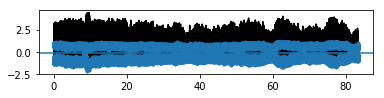

In [163]:
#flydir = '/home/alysha/media/imager/FlyDataD/lysh_ephys_ata_old/'
#flydir = '/home/alysha/media/imager/FlyDataD/brad_b2_data/'

#localfile = flydir + '2018_03_05_0024.abf'
#localfile = flydir + '2018_10_29_0009.abf'
localfile = flydir + '2018_12_10_0038.abf'
 
r =AxonIO(localfile)
 
bl = r.read_block(lazy=False, cascade=True)
 
hutch = np.asarray(bl.segments[0].analogsignals[5])
 
fs_axon = 1.0/20000.0
 
times=np.linspace(0,len(hutch)/(1/fs_axon),len(hutch))
 
# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)
 
ax1 = plt.subplot(311)
 
ax1.plot(times,hutch_det,'k')
 
#identify all relative minima
from scipy.signal import argrelmin
inds = argrelmin(hutch_det, order = 5)
ax1.plot(times[inds], hutch_det[inds], '.')
ax1.axhline(-0.08)
inds = np.array(inds)
inds = np.transpose(inds)
 

In [164]:
 
## identify the ventral flip of each wingbeat by applying a threshold
thresh = -.01 #adjust as needed
flipInds = []
flipInds = np.argwhere(hutch_det[inds]>thresh)
flipInds = inds[flipInds]
flipInds = flipInds[:,0]
 
#% now find the phase of the ventral flip 
 
#filter hütchen signal to make it more sinusoidal
 
from scipy import signal
from scipy.signal import butter, lfilter, freqz
 
def butter_lowpass(highcut, fs, order=4):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 

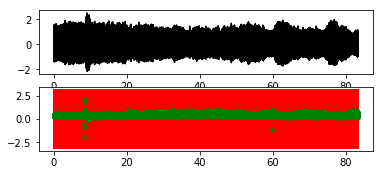

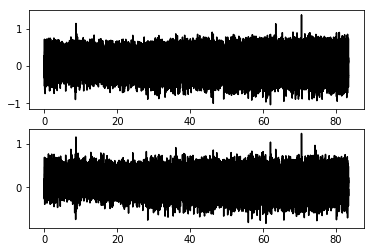

In [165]:
 
# Filter requirements.
order = 4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 300.0  # desired cutoff frequency of the filter, Hz
 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(highcut, fs, order)
 
 
hutch_filt = signal.filtfilt(b, a, hutch_det)
 
ax2 = plt.subplot(312, sharex=ax1)
 
ax2.plot(times,hutch_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
hutch_analytic = hilbert(hutch_filt)
inst_phase = np.angle(hutch_analytic)
 
 
ax3 = plt.subplot(313, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,hutch_analytic,'k')
ax3.plot(times,inst_phase,'r')
ax3.plot(times[flipInds],inst_phase[flipInds],'g.')


#%% detect muscle spikes and sort them
 
musc = np.asarray(bl.segments[0].analogsignals[0])
 
plt.figure(2)
ax1 = plt.subplot(211)
ax1.plot(times,musc,'k')
 
#apply median filter and detrend muscle signal
 
musc_det = musc-signal.medfilt(musc,35)
 
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times,musc_det,'k')
 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh =  0.6 #1.1
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]

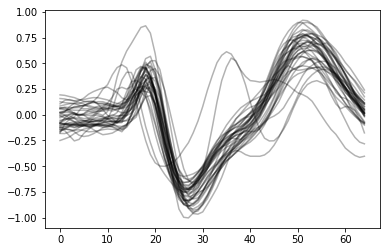

In [166]:
  
#find the peak changes in the thresholded signal, and find the associated waveform   
intervals = np.hstack((starts,stops))
spiketimes = [np.argmax(musc[sta:stp])+sta for sta,stp in intervals][2:-2]
waveforms = [musc[pk-25:pk+40] for pk in spiketimes]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(waveforms)):
    plt.plot(waveforms[i], 'k', alpha = 0.3)
 
wv_mtrx = np.vstack([np.array(wv) for wv in waveforms])

 
#%% extract the features of the waveforms to cluster the data
 
cov_wav = np.cov(wv_mtrx.T)
eig_vals, eig_vecs = np.linalg.eig(cov_wav)
#for ev in eig_vecs:
    #np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

[[-2.3004967  -0.9864744 ]
 [ 0.64649391 -0.37342054]]


/usr/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype complex128 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


' \ntest3 = np.argwhere(labels=0)\n\nfor i in range(len(test3)):\n   plt.plot(wv_mtrx[test3[i]])\n'

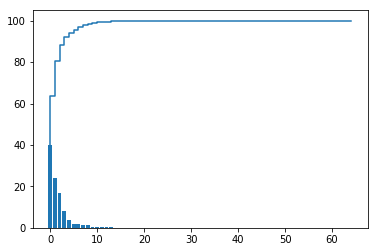

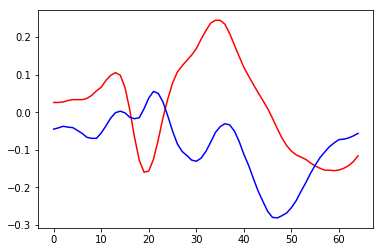

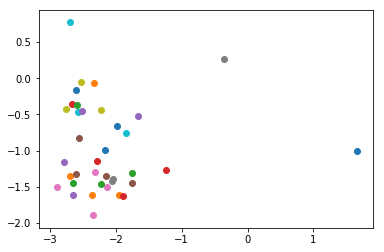

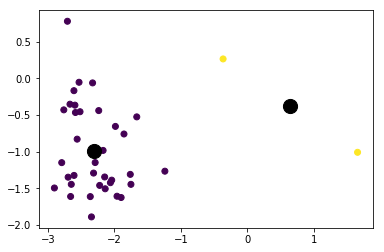

In [167]:
 
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
 
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
 
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
 
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
 
plt.figure(4)
plt.bar(range(65), var_exp)
plt.step(range(65), cum_var_exp)
 
#contruct the projection matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(65,1),
                      eig_pairs[1][1].reshape(65,1)))
 
plt.figure(5)
plt.plot(matrix_w[:,0],'r')
plt.plot(matrix_w[:,1],'b')
 
plt.figure(6)
proj = []
proj1 = []
proj2 =[]
for i in range(len(wv_mtrx)):
    musc_proj = np.dot(wv_mtrx[i], matrix_w)
    proj.append(musc_proj[0])
    proj1.append(musc_proj[1])
    proj2.append(musc_proj)
    plt.scatter(musc_proj[0], musc_proj[1])
 
     
X = np.array(list(zip(proj, proj1)))
 
#%%
from sklearn.cluster import KMeans
 
# Number of clusters
#kmeans = KMeans(n_clusters=2)
#n_clusters=1
n_clusters=2
kmeans = KMeans(n_clusters=2)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
 
#print(C) 
print(centroids)
 
plt.figure(7)
plt.scatter(X[:, 0], X[:, 1], c=labels)
 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200);
 
""" 
test3 = np.argwhere(labels=0)
 
for i in range(len(test3)):
    plt.plot(wv_mtrx[test3[i]])
"""

In [168]:
    
#%%


###### categorize and plot the labels 

labeled_spikes= zip(spiketimes,labels)

In [169]:
def cutoff(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

#Type_a_spikes = cutoff(0.5, labeled_spikes)
Type_a_spikes = cutoff(0.5, labeled_spikes)

In [170]:
def cutoff_2(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_b_spikes = cutoff_2(0.5, labeled_spikes)

In [171]:
#print(zip_hutch)
#
x_val = [x[0] for x in Type_a_spikes]
y_val = [x[1] for x in Type_a_spikes]

Type_b_spikes = Type_a_spikes

x_val_b = [x[0] for x in Type_b_spikes]
y_val_b = [x[1] for x in Type_b_spikes]



labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(labeled_waveforms_type_a)):
    plt.plot(labeled_waveforms_type_a[i], 'b', alpha = 0.3)

plt.figure(3)
for i in range(len(labeled_waveforms_type_b)):
    plt.plot(labeled_waveforms_type_b[i], 'r', alpha = 0.3)

#%%
### delete this freq shit
###Use Hilbert function againt o calculate the instantaneous freq. of B2

plt.figure(12)

# Filter requirements.
order = 10  #4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 200.0  # desired cutoff frequency of the filter, Hz

IndexError: string index out of range

Brad, the chrimson signal was moved to channel 12 for your recordings/the more recent ones!

Use the commented out bit below:
#crimson = np.asarray(bl.segments[0].analogsignals[12])

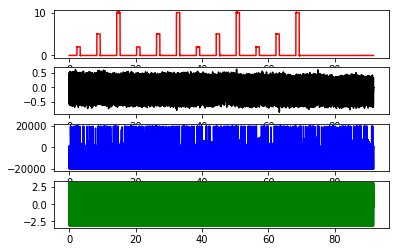

In [132]:
crimson = np.asarray(bl.segments[0].analogsignals[12])
#crimson = np.asarray(bl.segments[0].analogsignals[7])

def butter_lowpass_1(highcut, fs, order=10):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 
 

 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass_1(highcut, fs, order)
 
 
muscb2_filt = signal.filtfilt(b, a, musc_det)

ax1 = plt.subplot(411)
ax1.plot(times, crimson, 'r')
 
ax2 = plt.subplot(412, sharex=ax1)
 
ax2.plot(times,muscb2_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
musc_analytic = hilbert(muscb2_filt)
inst_phase = np.angle(musc_analytic)

#instantaneous_phase = np.unwrap(np.angle(musc_analytic))
instantaneous_frequency = (np.diff(inst_phase) /(2.0*np.pi) * fs)
 
ax3 = plt.subplot(413, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,musc_analytic,'k')
#ax3.plot(times,inst_phase,'r')

times_freq = np.delete(times,  971775)

ax3.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(times, inst_phase, 'g')

In [66]:
#ax1 = plt.subplot(611)

#ax1.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

IndexError: list index out of range

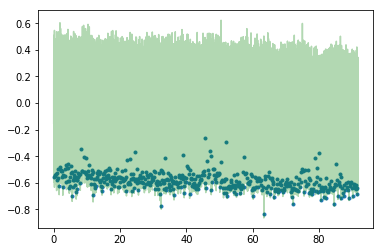

In [133]:
#%%



### delete this freq shit also 
import numpy as np
#data = musc[x_val]
data = musc[x_val_b]
#data = muscb2_filt
import seaborn as sns
data1 = muscb2_filt[x_val_b]
#data1 = muscb2_filt[x_val]
from scipy.signal import savgol_filter

#detect B2 spikes-- Use negative values

#times_between_spikes =  

plt.figure(13)

labeled_b2_spikes= zip(times[x_val_b], muscb2_filt[x_val_b])
ax1 = plt.subplot(111)
#inds_b2 = argrelmin(muscb2_filt[x_val_b], order = 5)
#ax1.plot(times[inds_b2], muscb2_filt[inds_b2], '.')
ax1.plot(times[x_val_b], muscb2_filt[x_val_b], '.')
ax1.plot(times, muscb2_filt, 'g', alpha = 0.3)

def cutoff_3(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Detected_spikes = cutoff_3(0.2, labeled_b2_spikes)

times_k= []
periods = []

for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)


In [18]:
'''
times_k= []
periods = []



for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)
'''

'\ntimes_k= []\nperiods = []\n\n\n\nfor i in range(len(times)):\n    for t in range(len(x_val_b)):\n        #z = times[x_val_b[t-2]]\n        a = times[x_val_b[t]]\n        b = times[x_val_b[t-1]]\n        c = times[x_val_b[t+1]]\n        #d = times[x_val_b[t+2]]\n        if t<= 2:\n            periods.append(100)\n        else:\n            times_k.append(times[x_val_b[t]])\n            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4\n            periods.append(avg)\n            #if \n              #  periods.append(a-b)\n'

In [134]:
spike_window = 3
window = 10

times_p =[]
periods =[]

avg = 100

for i in range(len(times)):
    if i in x_val_b[1:]:
        c = x_val_b.index(i)
        a = times[x_val_b[c]]
        b = times[x_val_b[c-1]]
        #c = times[x_val_b[i+1]]
        #d = times[x_val_b[t+2]]
        if c<= 1:
            periods.append(100)
        else:
            times_p.append(times[x_val_b[c]])
            #print ('spike')
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
    else:
        periods.append(avg)
        


KeyboardInterrupt: 

In [135]:
spike_window = 3
window = 10

times_p =[]
periods =[]

avg = 300

gaussian_window = 1000

gaussian_spike_count = []

times_inds = np.arange(len(times))

for i in times_inds[::50]:
    spike_count = 0
    for j in range((gaussian_window)):
        j= j-500
        if i+j in x_val_b:
            #c = x_val_b.index(i)
            #spike_count = 0
            spike_count = spike_count + 1
            #c = times[x_val_b[i+1]]
            #d = times[x_val_b[t+2]]
            #if c<= 1:
            #    periods.append(100)
            #else:
            #    times_p.append(times[x_val_b[c]])
            #    #print ('spike')
            #    avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            #    periods.append(avg)
    if spike_count > 0:
        gaussian_spike_count.append(spike_count)
    else: 
        gaussian_spike_count.append(spike_count)
        


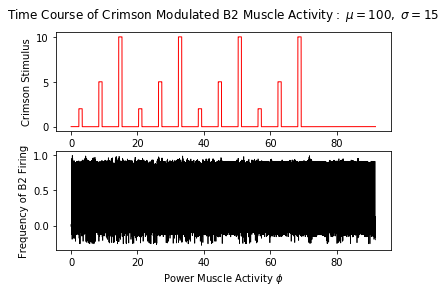

In [136]:

plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times[::50], crimson[::50], 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
#ax2.set_ylim(-5, 20)
#savitzky_golay
freq_hat = savgol_filter(gaussian_spike_count, 115, 9) # window size 51, polynomial order 3

#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)

#ax2.plot(times, freq_hat[:-3],'k', linewidth = 0.75)
ax2.plot(times[::50], freq_hat,'k', linewidth = 0.75)

#peristimulus time historgram

#and then compute the Fourier transform as


#plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')

ax1.set_ylabel('Crimson Stimulus', size=10)
ax1.set_title(r'$\mathrm{Time\ Course\ of\ Crimson\ Modulated\ B2\ Muscle\ Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of B2 Firing', size=10)
plt.xlabel('Power Muscle Activity $\phi$', size=10)

import numpy.fft as fft
spectrum = fft.fft(data1)
#You can then plot the magnitudes of the FFT as

In [346]:
savgol_filter

<function scipy.signal._savitzky_golay.savgol_filter>

In [233]:
print(len(periods))
print(len(times))


0
1590272


In [234]:
b2_frequencies = [1/period for period in periods]
len (b2_frequencies)

0

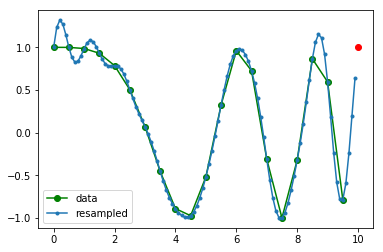

In [18]:
import pandas as pd

In [137]:


#power_muscle_frequencies_df = pd.DataFrame((b2_frequencies))
#power_muscle_frequencies_df.to_csv('s104_i1_01_frequencies_df.csv', index=False)

i1_frequencies_df = pd.DataFrame((gaussian_spike_count))
i1_frequencies_df.to_csv('s110_pm_03_frequencies_df.csv', index=False)

i1_frequencies_savgol_df = pd.DataFrame((freq_hat))
i1_frequencies_savgol_df.to_csv('s110_pm_03_frequencies_savgol_df.csv', index=False)


#periods_df = pd.DataFrame((periods))
#periods_df.to_csv('s104_i1_01_periods_df.csv', index=False)



In [138]:
chrimson_df = pd.DataFrame((crimson))
chrimson_df.to_csv('s110_pm_chrimson_03_df.csv', index=False)

In [139]:
times_df = pd.DataFrame(times)
times_df.to_csv('s110_pm_times_03_df.csv', index=False)

The last few cells are probably the ones you're after.  So here you can see (vs the other notebook I sent you) the limitations of the direct data period/freq analysis.  This will be ameliorated a bit by increasing the sample size.  However, the other approach I tried before (that I can also try and recreate) was running these raw traces through filters to try get slightly smoother.

In [140]:
f1 = pd.read_csv('s110_pm_03_frequencies_df.csv')
f2 = pd.read_csv('s110_pm_03_frequencies_savgol_df.csv')
f3 = pd.read_csv('s110_pm_chrimson_03_df.csv')
f4 = pd.read_csv('s110_pm_times_03_df.csv')


In [141]:
df = pd.DataFrame()

# Add a new columns with impoact force in units of Newtons
df['i1 frequencies'] = f1
df['i1 frequencies_savgol'] = f2
df['chrimson stimulus'] = f3
df['times'] = f4

# Take a look
df.head()

,i1 frequencies,i1 frequencies_savgol,chrimson stimulus,times
0,0,0.018331,0.009155,0.00000
1,0,0.007076,0.009155,0.00005
2,0,-0.001644,0.009155,0.00010
3,0,-0.007838,0.009155,0.00015
4,0,-0.011653,0.009155,0.00020


In [142]:
max_chrimson_stim = df['chrimson stimulus'] >= 9.9
#max_chrimson_stim.head()

max_inds = df.loc[max_chrimson_stim]
max_inds.head()

,i1 frequencies,i1 frequencies_savgol,chrimson stimulus,times


In [143]:
crimson_on = []
crimson_off = []

for f in range(len(f3)-1):
    #if crimson[f]-crimson[f-1]>= 1.05:  #1.55
    #    crimson_on.append(f)
    if crimson[f]-crimson[f-1]>= .65:  #1.55
        crimson_on.append(f)
    if crimson[f]-crimson[f+1] >= 1.05:  #<= - 0.75:
        crimson_off.append(f)

In [144]:
#new_crimson_on = []
#new_crimson_off = []

for i in range(len(crimson_on)-1): 
    if crimson_on[i] - crimson_on[i+1] >= - 100:
        del crimson_on[i+1]
        #new_crimson_on.append[crimson_on[i]]

for i in range(len(crimson_off)-1): 
    if crimson_off[i] - crimson_off[i+1] >= - 100:
        del crimson_off[i+1]
        #new_crimson_on.append[crimson_on[i]]

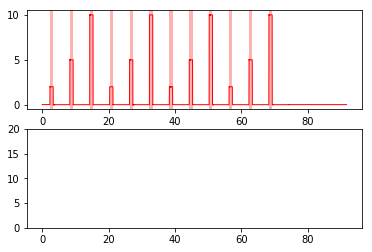

In [145]:
fig =plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(0, 20)
#ax2.set_xlim(20, 80)
#savitzky_golay
'''freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'''
#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)
        
for i in range(len(crimson_on)):
    ax1.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)
    #ax2.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)

In [244]:
print(len(crimson_on), (crimson_on)) 
print(len(crimson_off), (crimson_off))

(12, [52077, 172114, 292118, 412114, 532118, 652117, 772117, 892110, 1012113, 1132113, 1252116, 1372115])
(12, [72073, 192117, 312112, 432116, 552117, 672111, 792116, 912114, 1032114, 1152111, 1272114, 1392112])


In [83]:
'''
df_freq_upon_signal = pd.DataFrame()

for i in range(len(crimson_on)):
    on_signal = crimson_on[i]
    f = b2_frequencies[on_signal-5000: on_signal+10000]
    
    f2 = signal.resample(y2, )
    xnew = np.linspace(0, times[len(y2)-1], 180000000, endpoint=False)
    
    
    
    df_freq_upon_signal[i]=f
'''

**** switch here to make the fixed time on the chrimson time scale and then
upsample in the lower frequency area

In [ ]:
#***duplicate older version

#df_freq_upon_signal = pd.DataFrame()

#for i in range(len(crimson_on)):
#    on_signal = crimson_on[i]
#    off_signal = crimson_off[i]
#    f = b2_frequencies[on_signal-5000: off_signal+1000]
#    df_freq_upon_signal[i]=f

In [199]:
crimson_off[0] + 1000 - crimson_on[0] + 2500 

23498

d={}
for x in range(1,10):
        d["crimson{0}".format(i)]="Hello"

In [ ]:
CHANGE FLY NUM

In [149]:
'''

#df_freq_upon_signal_2 = pd.DataFrame()
df_freq_upon_signal_4 = pd.DataFrame()
d={} 

for i in range(len(crimson_on)-1):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
    if i != 0:
        if i !=len(crimson_on): 
            next_off_signal = crimson_off[i+1]
            next_on_signal = crimson_on[i+1]
            prior_off_signal = crimson_off[i-1]
            alt_f = b2_frequencies[prior_off_signal: next_on_signal]
        
            f3 = signal.resample(alt_f, 10000)
            xnew3 = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)
            df_freq_upon_signal_4[i]=f3
            resampled_crim = signal.resample(crimson[prior_off_signal: next_on_signal],10000)
            resampled_times = signal.resample(times[prior_off_signal: next_on_signal],10000)
            d["fly14_b2_df{0}".format(i)]=f3
            d["fly14_crimson{0}".format(i)]=resampled_crim
            d["fly14_times{0}".format(i)]= resampled_times
        
    #f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    #f2 = signal.resample(f, 500000)
    #xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    #x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    #df_freq_upon_signal_2[i]=f2
    
'''

'\n\n#df_freq_upon_signal_2 = pd.DataFrame()\ndf_freq_upon_signal_4 = pd.DataFrame()\nd={} \n\nfor i in range(len(crimson_on)-1):\n    on_signal = crimson_on[i] - 2500\n    off_signal = crimson_off[i] + 1000\n    \n    #prior_off_signal = crimson_off[i-1]\n    if i != 0:\n        if i !=len(crimson_on): \n            next_off_signal = crimson_off[i+1]\n            next_on_signal = crimson_on[i+1]\n            prior_off_signal = crimson_off[i-1]\n            alt_f = b2_frequencies[prior_off_signal: next_on_signal]\n        \n            f3 = signal.resample(alt_f, 10000)\n            xnew3 = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)\n            df_freq_upon_signal_4[i]=f3\n            resampled_crim = signal.resample(crimson[prior_off_signal: next_on_signal],10000)\n            resampled_times = signal.resample(times[prior_off_signal: next_on_signal],10000)\n            d["fly14_b2_df{0}".format(i)]=f3\n            d["fly14_crimson{0}".format(i)]=resampled_cr

In [146]:
freq_hat_upsampled = signal.resample(freq_hat, len(freq_hat)*50)


#df_freq_upon_signal_2 = pd.DataFrame()
df_freq_upon_signal_4 = pd.DataFrame()
d={} 

for i in range(len(crimson_on)-1):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
    if i != 0:
        if i !=len(crimson_on): 
            next_off_signal = crimson_off[i+1]
            next_on_signal = crimson_on[i+1]
            prior_off_signal = crimson_off[i-1]
            alt_f = freq_hat_upsampled[prior_off_signal: next_on_signal]
        
            f3 = signal.resample(alt_f, 10000)
            xnew3 = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)
            df_freq_upon_signal_4[i]=f3
            resampled_crim = signal.resample(crimson[prior_off_signal: next_on_signal],10000)
            resampled_times = signal.resample(times[prior_off_signal: next_on_signal],10000)
            d["fly03_pm_df{0}".format(i)]=f3
            d["fly03_crimson{0}".format(i)]=resampled_crim
            d["fly03_times{0}".format(i)]= resampled_times
        
    #f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    #f2 = signal.resample(f, 500000)
    #xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    #x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    #df_freq_upon_signal_2[i]=f2

In [147]:
d

{'fly03_crimson1': array([0.09251843, 0.00123222, 0.00184093, ..., 0.00134733, 0.00190441,
        0.00132661]),
 'fly03_crimson10': array([0.09209178, 0.00175849, 0.001405  , ..., 0.00168283, 0.00152539,
        0.00174192]),
 'fly03_crimson2': array([0.22951971, 0.00115374, 0.0024161 , ..., 0.00109375, 0.00220426,
        0.00101279]),
 'fly03_crimson3': array([0.43449275, 0.0014979 , 0.00173014, ..., 0.00153421, 0.00171368,
        0.00144538]),
 'fly03_crimson4': array([0.09275998, 0.001301  , 0.00190734, ..., 0.00132578, 0.00189065,
        0.00128788]),
 'fly03_crimson5': array([0.22931836, 0.00096797, 0.00211902, ..., 0.0011586 , 0.00224753,
        0.0011406 ]),
 'fly03_crimson6': array([0.45629057, 0.00154095, 0.00166424, ..., 0.00137835, 0.00178891,
        0.0014595 ]),
 'fly03_crimson7': array([0.09272735, 0.00138507, 0.00174812, ..., 0.00123381, 0.00188273,
        0.00136363]),
 'fly03_crimson8': array([0.22938291, 0.00121641, 0.00212819, ..., 0.00091946, 0.00197986,
    

In [148]:
resampled_df = pd.DataFrame(d)
resampled_df.head()

,fly03_crimson1,fly03_crimson10,fly03_crimson2,fly03_crimson3,fly03_crimson4,fly03_crimson5,fly03_crimson6,fly03_crimson7,fly03_crimson8,fly03_crimson9,...,fly03_times1,fly03_times10,fly03_times2,fly03_times3,fly03_times4,fly03_times5,fly03_times6,fly03_times7,fly03_times8,fly03_times9
0,0.092518,0.092092,0.229520,0.434493,0.092760,0.229318,0.456291,0.092727,0.229383,0.455899,...,8.578355,62.579709,14.578358,20.578211,26.578289,32.578268,38.578271,44.578124,50.578203,56.579731
1,0.001232,0.001758,0.001154,0.001498,0.001301,0.000968,0.001541,0.001385,0.001216,0.001604,...,2.347154,56.346711,8.347099,14.346834,20.347001,26.347008,32.347071,38.346747,44.346973,50.346762
2,0.001841,0.001405,0.002416,0.001730,0.001907,0.002119,0.001664,0.001748,0.002128,0.001748,...,3.864189,57.864168,9.864147,15.863910,21.864056,27.864057,33.864106,39.863824,45.864015,51.864212
3,0.001286,0.001646,0.001106,0.001343,0.001327,0.001037,0.001592,0.001330,0.000876,0.001629,...,2.968441,56.968170,8.968391,14.968138,20.968296,26.968301,32.968357,38.968051,44.968262,50.968218
4,0.001871,0.001509,0.002314,0.001811,0.001943,0.002148,0.001993,0.001888,0.002054,0.001631,...,3.607730,57.607638,9.607686,15.607445,21.607594,27.607596,33.607647,39.607358,45.607555,51.607683


In [149]:
from scipy import stats

In [150]:
fly_14_b2_mean_freq_change = df_freq_upon_signal_4.mean(axis=1)
fly_14_b2_freq_error = stats.sem(df_freq_upon_signal_4,axis = 1)

In [151]:
#fly_01_b2_mean_freq_change.iloc[0]
fly_14_b2_mean_freq_change_series = fly_14_b2_mean_freq_change.T
#type(_)
type(fly_14_b2_mean_freq_change_series)

pandas.core.series.Series

In [48]:
#fly_01_b2_mean_freq_change_series

In [152]:
type(fly_14_b2_mean_freq_change)
type(fly_14_b2_freq_error)
#fly_01_b2_freq_error
#fly_01_b2_freq_error = pd.Series(fly_01_b2_freq_error)
#shape(fly_01_b2_freq_error)
#fly_01_b2_mean_freq_change = df.values(fly_01_b2_mean_freq_change)

numpy.ndarray

In [50]:
#fly_01_b2_mean_freq_change.head()
#fly_01_b2_freq_error = pd.DataFrame(fly_01_b2_freq_error)

In [153]:
d["fly_03_pm_mean_freq_change_series"]=fly_14_b2_mean_freq_change_series
d["fly_03_pm_freq_error"]=fly_14_b2_freq_error

In [154]:
resampled_df = pd.DataFrame(d)
resampled_df.head()

,fly03_crimson1,fly03_crimson10,fly03_crimson2,fly03_crimson3,fly03_crimson4,fly03_crimson5,fly03_crimson6,fly03_crimson7,fly03_crimson8,fly03_crimson9,...,fly03_times2,fly03_times3,fly03_times4,fly03_times5,fly03_times6,fly03_times7,fly03_times8,fly03_times9,fly_03_pm_freq_error,fly_03_pm_mean_freq_change_series
0,0.092518,0.092092,0.229520,0.434493,0.092760,0.229318,0.456291,0.092727,0.229383,0.455899,...,14.578358,20.578211,26.578289,32.578268,38.578271,44.578124,50.578203,56.579731,0.081446,0.395824
1,0.001232,0.001758,0.001154,0.001498,0.001301,0.000968,0.001541,0.001385,0.001216,0.001604,...,8.347099,14.346834,20.347001,26.347008,32.347071,38.346747,44.346973,50.346762,0.129124,0.477782
2,0.001841,0.001405,0.002416,0.001730,0.001907,0.002119,0.001664,0.001748,0.002128,0.001748,...,9.864147,15.863910,21.864056,27.864057,33.864106,39.863824,45.864015,51.864212,0.114074,0.459629
3,0.001286,0.001646,0.001106,0.001343,0.001327,0.001037,0.001592,0.001330,0.000876,0.001629,...,8.968391,14.968138,20.968296,26.968301,32.968357,38.968051,44.968262,50.968218,0.124715,0.471362
4,0.001871,0.001509,0.002314,0.001811,0.001943,0.002148,0.001993,0.001888,0.002054,0.001631,...,9.607686,15.607445,21.607594,27.607596,33.607647,39.607358,45.607555,51.607683,0.119265,0.462425


In [155]:
resampled_df.to_csv('/home/alysha/analysis_files/S110/s110_pm_df_fly_03.csv', index=False)



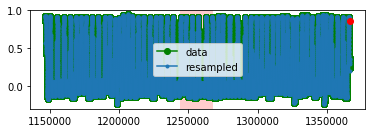

In [156]:
fig =plt.figure(18)

x = np.arange(prior_off_signal, next_on_signal)
xnew = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)

ax2 = fig.add_subplot(212)

import matplotlib.pyplot as plt
plt.plot(x, alt_f, 'go-', xnew, f3, '.-', next_on_signal, alt_f[11], 'ro')
ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
#ax2.axvspan(prior_on_signal, prior_off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [67]:
#print(outliers)

#new_df = df_freq_upon_signal.drop(17, axis=1)#.head()

In [157]:
#new_df = df_freq_upon_signal_2
new_df = df_freq_upon_signal_4

In [212]:
#fig =plt.figure(18)

#x = np.arange(prior_off_signal, next_on_signal)
#xnew = np.linspace(prior_off_signal, next_on_signal, 1000000, endpoint=False)

#ax2 = fig.add_subplot(212)

#import matplotlib.pyplot as plt
#plt.plot(x, alt_f, 'go-', xnew, f3, '.-', next_on_signal, alt_f[11], 'ro')
#ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
##ax2.axvspan(prior_on_signal, prior_off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
#plt.legend(['data', 'resampled'], loc='best')
#plt.show()

'freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'

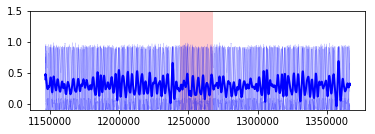

In [158]:
fig =plt.figure(15)

ax1 = plt.subplot(211)

for i in new_df:
    ax1.plot(xnew, new_df[i], 'b', linewidth =0.5, alpha = 0.2)
    
    
ax1.set_ylim((-.1,1.5))
#ax1.set_ylimit(-0.1, 100)
#ax1.set_xlim((1200000,1300000))


mean_freq_change = new_df.mean(axis=1)
ax1.plot(xnew, mean_freq_change, 'b', linewidth =2.0)

ax1.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)

'''
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(0, 20)
#ax2.set_xlim(20, 80)
#savitzky_golay
'''
'''freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'''
#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)
        
#for i in range(len(crimson_on)):
#    ax1.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)
#    #ax2.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)

In [159]:
from scipy import stats

In [160]:
mean_freq_change = new_df.mean(axis=1)
freq_error = stats.sem(new_df,axis = 1)

Text(0.5,0,u'Time (s)')

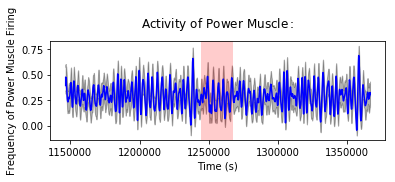

In [161]:
fig =plt.figure(16)


#wbf_means = wbf_means[0:len(wbf_means):10]
#wbf_error = stats.sem(all_wbf,axis = 0)
#wbf_error = wbf_error[0:len(wbf_error):10]

ax2 = fig.add_subplot(212)

#ax2.set_ylim((-30,150))
#ax1.set_ylimit(-0.1, 100)
#ax2.set_xlim((1220000,1300000))
#ax2.set_xlim((1340000,1400000))

#ax2.axvspan(0.25, .75, facecolor = 'r', edgecolor = 'none', alpha = 0.3)
ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
ax2.plot(xnew,mean_freq_change, 'b')
ax2.fill_between(xnew,mean_freq_change+freq_error, mean_freq_change-freq_error,color='k', alpha = 0.3, edgecolor = 'none')

ax2.set_title(r'$\mathrm{Activity\ of\ Power \ Muscle:}$', size=12, horizontalalignment='center',  y=1.08)#   \ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of Power Muscle Firing', size=10)
plt.xlabel('Time (s)', size=10) # $\phi$', size=10)
#ax2.title('B2 spike frequency')

In [ ]:
### Then plot this over time
### Update on git -- new analysis file for each genotype
### Develop a pattern of dataframe organization
### blue card 
### bills
### analysis
### tutor
### cv website
### laudry 


In [162]:
#altair and bokeh plotting

new_df.to_csv('s110_pm_03_df.csv', index=False)